# [Insert Title]

## Imports

In [133]:
#import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xg
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,log_loss, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from imblearn.over_sampling import SMOTE, SMOTENC

## Functions

In [2]:
def scores(actual, pred):
    print("log loss: ", log_loss(actual, pred))
    print("accuracy: ", accuracy_score(actual, pred))
    print("precision:", precision_score(actual, pred))
    print("recall:   ", recall_score(actual, pred))

## Data Manipulation

In [3]:
df = pd.read_csv('data/syrialtel_cleaned_data.csv')

In [4]:
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,total_calls,total_charge,charge_per_min_day,charge_per_min_eve,charge_per_min_night,charge_per_min_dom,charge_per_min_int,%_int_min,call_satisfaction,region
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,...,303,75.56,0.409727,0.169495,0.120989,0.242867,0.900000,1.394311,0.330033,Midwest
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,...,332,59.24,0.223333,0.161359,0.111165,0.168815,1.233333,2.191299,0.301205,Midwest
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,...,333,62.29,0.362982,0.093636,0.070385,0.179878,0.658000,2.261772,0.000000,Northeast
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,...,255,66.80,0.716901,0.059773,0.099551,0.262177,0.254286,1.168555,0.784314,Midwest
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,...,359,52.09,0.250796,0.103361,0.069504,0.138652,0.910000,1.972656,0.835655,South


The data is split to a train and test data

In [5]:
#seperating the target and data
X = df.drop('churn', axis=1)
y = df['churn']

#creating a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Splitting the data between categorical and continuous

In [6]:
categorical = ['state','area_code', 'international_plan', 'voice_mail_plan', 'region']
df_cat = X_train[categorical]
df_cont = X_train.drop(categorical,axis = 1)

In [7]:
df_cont

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,total_minutes,total_calls,total_charge,charge_per_min_day,charge_per_min_eve,charge_per_min_night,charge_per_min_dom,charge_per_min_int,%_int_min,call_satisfaction
2016,80,0,202.4,118,34.41,260.2,67,22.12,177.4,112,...,649.2,302,66.99,0.291610,0.330149,0.071250,0.217205,0.496000,1.417129,0.993377
1362,63,0,132.9,122,22.59,67.0,62,5.70,160.4,121,...,370.2,307,38.18,0.185164,0.091935,0.059669,0.116426,1.335000,2.674230,0.977199
2670,116,12,221.0,108,37.57,151.0,118,12.84,179.0,80,...,560.0,312,60.90,0.347870,0.108814,0.100750,0.191078,0.405000,1.607143,0.641026
2210,71,0,278.9,110,47.41,190.2,67,16.17,255.2,84,...,736.0,268,78.22,0.431000,0.241343,0.136667,0.287586,0.451429,1.589674,0.000000
1846,120,43,177.9,117,30.24,175.1,70,14.88,161.3,117,...,525.8,308,55.49,0.258462,0.212571,0.062051,0.172303,0.777500,2.187143,0.324675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,106,0,274.4,120,46.65,198.6,82,16.88,160.8,62,...,639.8,267,72.39,0.388750,0.205854,0.116774,0.268068,0.540000,0.937793,0.374532
1130,122,0,35.1,62,5.97,180.8,89,15.37,251.6,58,...,480.2,211,36.09,0.096290,0.172697,0.195172,0.156268,1.715000,2.644731,0.473934
1294,66,0,87.6,76,14.89,262.0,111,22.27,184.6,125,...,543.4,317,47.95,0.195921,0.200631,0.066480,0.145737,0.496000,1.693044,0.315457
860,169,0,179.2,111,30.46,175.2,130,14.89,228.6,92,...,592.9,339,58.31,0.274414,0.114538,0.111848,0.167087,0.445000,1.669759,0.589971


In [8]:
#splitting the numericals and categoricals
X_num = df_cont.columns
X_cat = df_cat.columns

## Pipeline

In [9]:
#preprocessing
numTrans = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])
catTrans = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first',
                          sparse=False))
    ])

pp = ColumnTransformer(transformers=[
    ('num', numTrans, X_num),
    ('cat', catTrans, X_cat)
    ])

In [10]:
X_train_scaled = pp.fit_transform(X_train)
X_test_scaled = pp.transform(X_test)

In [11]:
cat_names = pp.transformers_[1][1].named_steps['ohe'].get_feature_names(X_cat).tolist()
feature_names= list(X_num) + cat_names

In [12]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

## Model 1: Baseline Log Regression

In [13]:
logreg_baseline = LogisticRegression(random_state=42, max_iter=2000)

logreg_baseline.fit(X_train_scaled, y_train)

logreg_baseline_cv = cross_val_score(logreg_baseline, X_train_scaled, y_train).mean()
print(logreg_baseline_cv)

0.8636884138552169


In [14]:
print(logreg_baseline.score(X_train_scaled, y_train))
print(logreg_baseline.score(X_test_scaled, y_test))

0.8769824260608658
0.867


## Model 2: K-Nearest Neighbors and Grid Search without SMOTE

In [15]:
knn_model = KNeighborsClassifier()

param_grid = {
    'n_neighbors': list(range(1, 20, 2)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3, 4],
}

gs_knn = GridSearchCV(knn_model, param_grid=param_grid, cv=5)
gs_knn.fit(X_train_scaled, y_train)

gs_knn.best_params_

{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}

In [16]:
gs_knn.score(X_train_scaled, y_train)

0.9074153450492928

In [17]:
gs_knn.score(X_test_scaled, y_test)

0.901

In [18]:
y_train_preds = gs_knn.predict(X_train_scaled)
y_test_preds = gs_knn.predict(X_test_scaled)

In [19]:
print(classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1993
           1       0.94      0.39      0.55       340

    accuracy                           0.91      2333
   macro avg       0.92      0.69      0.75      2333
weighted avg       0.91      0.91      0.89      2333



In [20]:
print(classification_report(y_test, y_test_preds))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       857
           1       0.96      0.32      0.48       143

    accuracy                           0.90      1000
   macro avg       0.93      0.66      0.71      1000
weighted avg       0.91      0.90      0.88      1000



In [21]:
print(confusion_matrix(y_train, y_train_preds))

[[1985    8]
 [ 208  132]]


In [22]:
print(confusion_matrix(y_test, y_test_preds))

[[855   2]
 [ 97  46]]


## Model 3: K-Nearest Neighbors and Grid Search with SMOTE

In [23]:
round(len(y_train[y_train==1])/len(y_train[y_train==0]),2)

0.17

In [24]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 2016 to 3174
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   2333 non-null   object 
 1   account_length          2333 non-null   int64  
 2   area_code               2333 non-null   int64  
 3   international_plan      2333 non-null   object 
 4   voice_mail_plan         2333 non-null   object 
 5   number_vmail_messages   2333 non-null   int64  
 6   total_day_minutes       2333 non-null   float64
 7   total_day_calls         2333 non-null   int64  
 8   total_day_charge        2333 non-null   float64
 9   total_eve_minutes       2333 non-null   float64
 10  total_eve_calls         2333 non-null   int64  
 11  total_eve_charge        2333 non-null   float64
 12  total_night_minutes     2333 non-null   float64
 13  total_night_calls       2333 non-null   int64  
 14  total_night_charge      2333 non-null

In [25]:
smote = SMOTENC([28, 29, 30, 31, 32, 33, 34],random_state=42, sampling_strategy=0.5)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_scaled, y_train)

In [26]:
knn_model = KNeighborsClassifier()

param_grid = {
    'n_neighbors': list(range(1, 20, 2)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3, 4],
}

gs_knn = GridSearchCV(knn_model, param_grid, cv=5, scoring='recall')
gs_knn.fit(X_train_resampled, y_train_resampled)

gs_knn.best_params_

{'n_neighbors': 1, 'p': 3, 'weights': 'uniform'}

In [27]:
gs_knn.score(X_train_scaled, y_train)

1.0

In [28]:
gs_knn.score(X_test_scaled, y_test)

0.5734265734265734

In [29]:
y_train_preds = gs_knn.predict(X_train_scaled)
y_test_preds = gs_knn.predict(X_test_scaled)

In [30]:
print(classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1993
           1       1.00      1.00      1.00       340

    accuracy                           1.00      2333
   macro avg       1.00      1.00      1.00      2333
weighted avg       1.00      1.00      1.00      2333



In [31]:
print(classification_report(y_test, y_test_preds))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88       857
           1       0.38      0.57      0.46       143

    accuracy                           0.80      1000
   macro avg       0.65      0.71      0.67      1000
weighted avg       0.84      0.80      0.82      1000



In [32]:
print(confusion_matrix(y_test, y_test_preds))

[[722 135]
 [ 61  82]]


## Decision Tree Model

In [73]:
#Instantiate a Decision Tree and perform 3-fold cross-validaiton on training data

DT_clf = DecisionTreeClassifier() 

DT_cv_score = cross_val_score(DT_clf, X_train_scaled, y_train, cv=3)

mean_DT_cv_score = np.mean(DT_cv_score)

print(f"Mean Cross Val Score: {mean_DT_cv_score:.2%}")

#Model did extremly well, perhaps a bit too well. We should take a look for any imbalances. 

Mean Cross Val Score: 94.56%


In [ ]:
#Create grid search parameters and intantiate GridSearch CV. Create different parameters and then fit the data. 

# DT_clf = DecisionTreeClassifier() 

# param_grid = { 
#     'criterion': ['gini', 'entropy'],
#     'max_depth': np.arange(1, 15, 2), #step up even higher 
#     'min_samples_split': np.arange(5, 120, 5),
#     'min_samples_leaf': np.arange(5, 120,5)
#     }

# gs_DT_clf = GridSearchCV(DT_clf, param_grid = param_grid, n_jobs = -1, scoring = "recall", cv = 5)

# gs_DT_clf.fit(X_train_scaled, y_train)
    
#SPECIFCY SCORING IN GRIDSEARCH TO RECALL? CURRENTLY ON ACCURACY: scoring = 'recall',  

#consistency in paramgrid search rationale 
#random CV search 

#After running it best parameter = 
# {'criterion': 'entropy',
#  'max_depth': 5,
#  'min_samples_leaf': 10,
#  'min_samples_split': 3}

In [77]:
best_DT_clf = DecisionTreeClassifier(criterion='entropy',
                                    max_depth= 5,
                                    min_samples_leaf= 10,
                                    min_samples_split= 3) 
best_DT_clf.fit(X_train_scaled, y_train)

y_train_preds = best_DT_clf.predict(X_train_scaled)
y_test_preds = best_DT_clf.predict(X_test_scaled)


In [78]:
print(classification_report(y_train, y_train_preds))
print(classification_report(y_test, y_test_preds))
print(confusion_matrix(y_test, y_test_preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1993
           1       1.00      0.81      0.90       340

    accuracy                           0.97      2333
   macro avg       0.98      0.91      0.94      2333
weighted avg       0.97      0.97      0.97      2333

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       857
           1       1.00      0.87      0.93       143

    accuracy                           0.98      1000
   macro avg       0.99      0.93      0.96      1000
weighted avg       0.98      0.98      0.98      1000

[[857   0]
 [ 19 124]]


In [79]:
best_DT_clf.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00637507,
       0.        , 0.0616826 , 0.        , 0.        , 0.1521506 ,
       0.        , 0.00577382, 0.        , 0.        , 0.        ,
       0.4187382 , 0.        , 0.        , 0.        , 0.        ,
       0.07633658, 0.        , 0.00295954, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

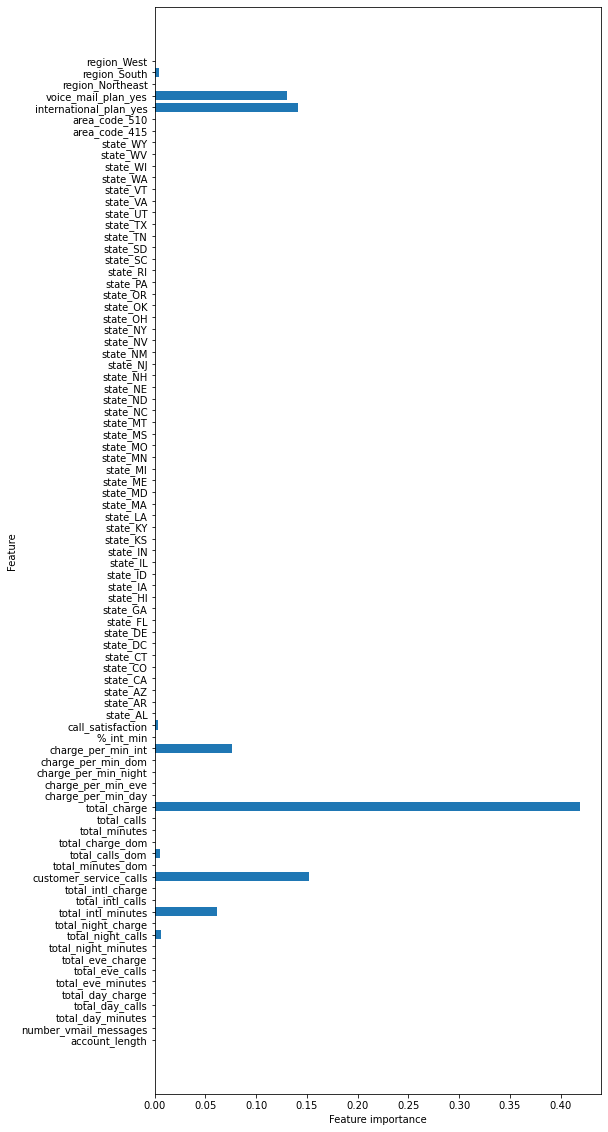

In [84]:
def plot_feature_importances(model):
    n_features = X_train_scaled.shape[1]
    plt.figure(figsize=(8,20))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train_scaled.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(best_DT_clf)

# Bagging Model

In [87]:
bagged_tree = BaggingClassifier(DecisionTreeClassifier(criterion = 'entropy', 
                                                       max_depth = 5, 
                                                       min_samples_leaf = 10, 
                                                       min_samples_split = 3), 
                                                       n_estimators = 20)

#Fit the model on training data
bagged_tree.fit(X_train_scaled, y_train)
#Training accuracy score 
bagged_tree.score(X_train_scaled, y_train)
#Test accuracy score
bagged_tree.score(X_test_scaled, y_test)

#make comment about overfit and why

0.981

# Random Forest

In [89]:
rf_model = RandomForestClassifier(criterion = 'entropy', 
                                  n_estimators = 1150, 
                                  max_depth=10, 
                                  bootstrap = True, 
                                  min_samples_split= 7)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_split=7,
                       n_estimators=1150)

In [92]:
def scores(actual, pred):
    print("log loss: ", log_loss(actual, pred))
    print("accuracy: ", accuracy_score(actual, pred))
    print("precision:", precision_score(actual, pred))
    print("recall:   ", recall_score(actual, pred))

In [95]:
rf_preds = rf_model.predict(X_test_scaled)
scores(y_test, rf_preds)

log loss:  1.3470122794015174
accuracy:  0.961
precision: 1.0
recall:    0.7272727272727273


In [97]:
# Grid Search for parameters, Played around with n_estimators before and found the optimal so excluded from this grid search
grid = {        
 'max_depth': [8,10],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 7]}

gs = GridSearchCV(estimator=rf_model, param_grid= grid, cv=2)
gs.fit(X_train_scaled, y_train)

GridSearchCV(cv=2,
             estimator=RandomForestClassifier(criterion='entropy', max_depth=10,
                                              min_samples_split=7,
                                              n_estimators=1150),
             param_grid={'max_depth': [8, 10], 'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 7]})

In [109]:
gs.best_params_
best_model= gs.best_estimator_
best_param=[]
for name, score in zip(X_train_scaled.columns, rf_model.feature_importances_):
    
    best_param.append((name,score))
best_param.sort(reverse= True, key=lambda x: x[1])
best_param[:10]

[('total_charge', 0.11603463923585035),
 ('total_charge_dom', 0.09165626921773305),
 ('customer_service_calls', 0.07603171274692963),
 ('call_satisfaction', 0.07278358632885197),
 ('international_plan_yes', 0.07258065463225186),
 ('total_day_minutes', 0.04704655008951919),
 ('total_day_charge', 0.043676277803954125),
 ('total_minutes', 0.03955641304780503),
 ('total_minutes_dom', 0.037589999038284985),
 ('number_vmail_messages', 0.029933485522696014)]

# XGBoost

In [113]:
xgb_model= xg.XGBClassifier(random_state=42, objective='binary:hinge', alpha=2)

In [115]:
xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(alpha=2, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:hinge', random_state=42, reg_alpha=2,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [116]:
y_preds_xgb = xgb_model.predict(X_test_scaled)
scores(y_test, y_preds_xgb)

log loss:  0.6907771270930749
accuracy:  0.98
precision: 0.984251968503937
recall:    0.8741258741258742


In [117]:
grid2 = {'eta': [.05,.1, .2, .4],
         'max_depth': [3,8,9],
         'alpha' : [1,2,3,4]
 }
gs = GridSearchCV(estimator=xgb_model, param_grid= grid2, cv=2)

In [119]:
gs.fit(X_train_scaled, y_train)

GridSearchCV(cv=2,
             estimator=XGBClassifier(alpha=2, base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1,
                                     objective='binary:hinge', random_state=42,
                                     reg_alpha=2, reg_lambda=1,
                                     scale_pos_weight=None, subsample=1,
              

In [120]:
gs.best_params_

{'alpha': 1, 'eta': 0.05, 'max_depth': 8}

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

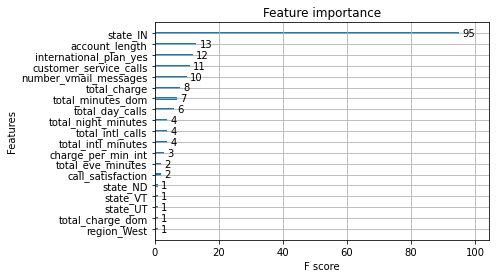

In [122]:
from xgboost import plot_importance
fit = xgb_model.fit(X_train_scaled, y_train)
plot_importance(fit)

In [124]:
xgb_model= xg.XGBClassifier(random_state=42, objective='binary:hinge', alpha=1, eta =.05, max_depth =3)
xgb_model.fit(X_train_scaled, y_train)
y_preds_xgb = xgb_model.predict(X_test_scaled)
scores(y_test, y_preds_xgb)

log loss:  0.5526204223185719
accuracy:  0.984
precision: 1.0
recall:    0.8881118881118881


# AdaBoost

In [130]:
model_boost_ada = AdaBoostClassifier(n_estimators=40,random_state=42)
model_boost_ada.fit(X_train_scaled,y_train)
model_boost_ada.predict(X_train_scaled)

model_boost_ada.score(X_train_scaled,y_train)


0.9262751821688813

In [128]:
y_preds= model_boost_ada.predict(X_test_scaled)
scores(y_test, y_preds)

log loss:  3.1430478422751973
accuracy:  0.909
precision: 0.76
recall:    0.5314685314685315


# Gradient Boost

In [129]:
model_boost_gb = GradientBoostingClassifier(random_state=42)
gb_m = model_boost_gb.fit(X_train_scaled,y_train)
model_boost_gb.score(X_train_scaled,y_train)

0.9819974282040291

In [131]:
y_preds= model_boost_gb.predict(X_test_scaled)
scores(y_test, y_preds)

log loss:  0.5526204223185719
accuracy:  0.984
precision: 1.0
recall:    0.8881118881118881


In [132]:
gradient_boost_cv = cross_val_score(gb_m, X_train_scaled, y_train, cv = 10)
gradient_boost_cv
gradient_boost_cv.mean()

0.9772862330802244

# Ensemble

In [152]:
voting_clf = VotingClassifier(estimators=[('lr', logreg_baseline), 
                                          ("rf", rf_model) ,
                                          ('dt', best_DT_clf),
                                          ('xgb', xgb_model)],
#                                           ("gb", gradient_boost_cv)], 
                                          voting= "soft")

In [153]:
voting_clf.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=2000,
                                                 random_state=42)),
                             ('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=10,
                                                     min_samples_split=7,
                                                     n_estimators=1150)),
                             ('dt',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=5,
                                                     min_samples_leaf=10,
                                                     min_samples_split=3)),
                             ('xgb',
                              XGBClassifier(alpha=1, base_score=0.5,
                                            booster='gbtree...
            